In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn

In [6]:
df = pd.read_excel('PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx')

In [7]:
df.head()

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,...,Relative change in PCF vs previous,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,...,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN


In [ ]:
#df.info()


# 2. Average CI across Countries

### Initial Inspection

In [8]:
# Average for each country
ci_avg = df.groupby('Country (where company is incorporated)')['*Carbon intensity'].mean()
ci_avg = ci_avg.sort_values(ascending = False)
print(ci_avg)

Country (where company is incorporated)
Canada            370.148333
Brazil            106.168235
France             60.863500
Malaysia           58.417500
USA                45.086623
Japan              44.831364
China              44.586667
Taiwan             29.098000
South Korea        22.316818
Germany            20.763582
United Kingdom     17.763125
Australia          10.500000
Finland             9.669714
Sweden              8.676923
Switzerland         6.869286
Netherlands         2.706571
Spain               2.445385
Italy               1.563478
India               1.536250
Luxembourg          1.370000
Belgium             1.175000
South Africa        1.106364
Ireland             0.855000
Indonesia           0.720000
Greece              0.700000
Chile               0.516667
Lithuania           0.360000
Colombia            0.175000
Name: *Carbon intensity, dtype: float64


In [10]:
sorted_countries = ci_avg.index.tolist()

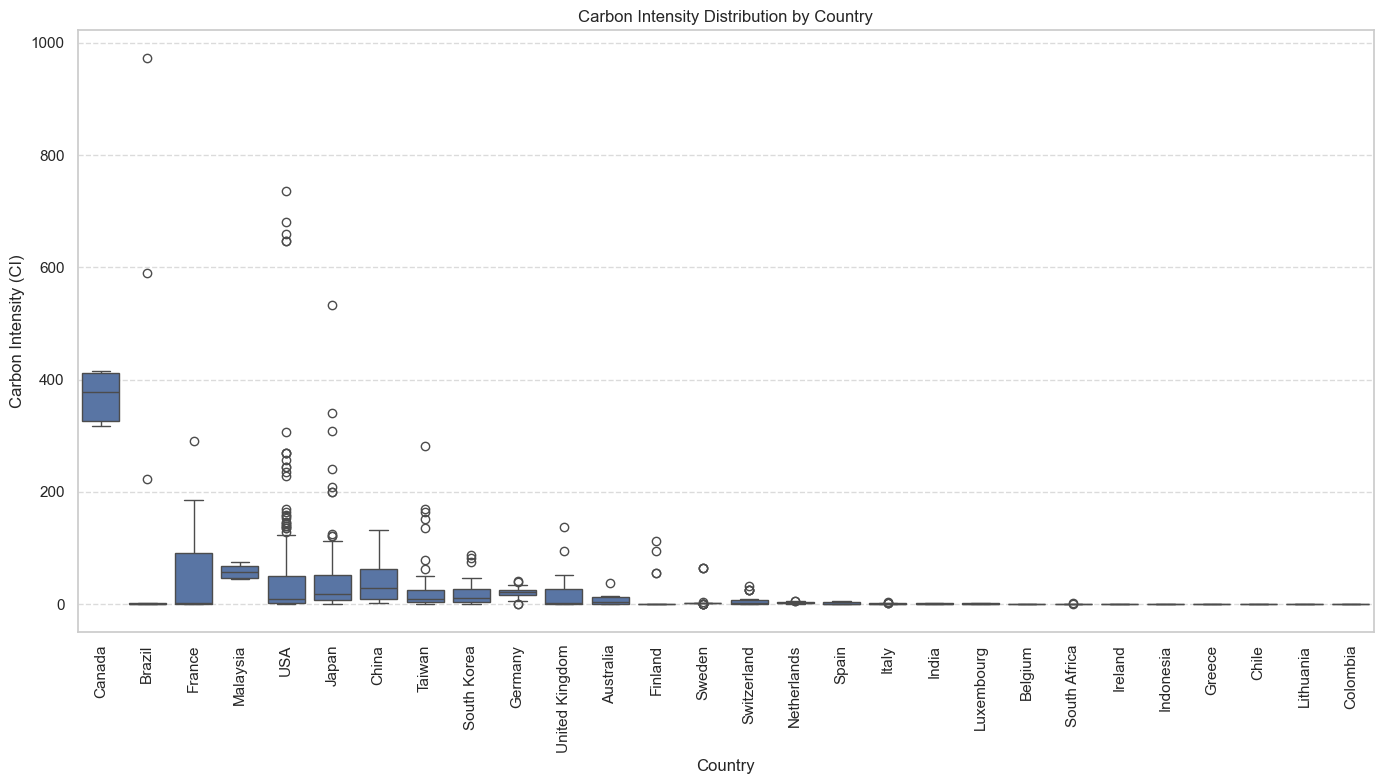

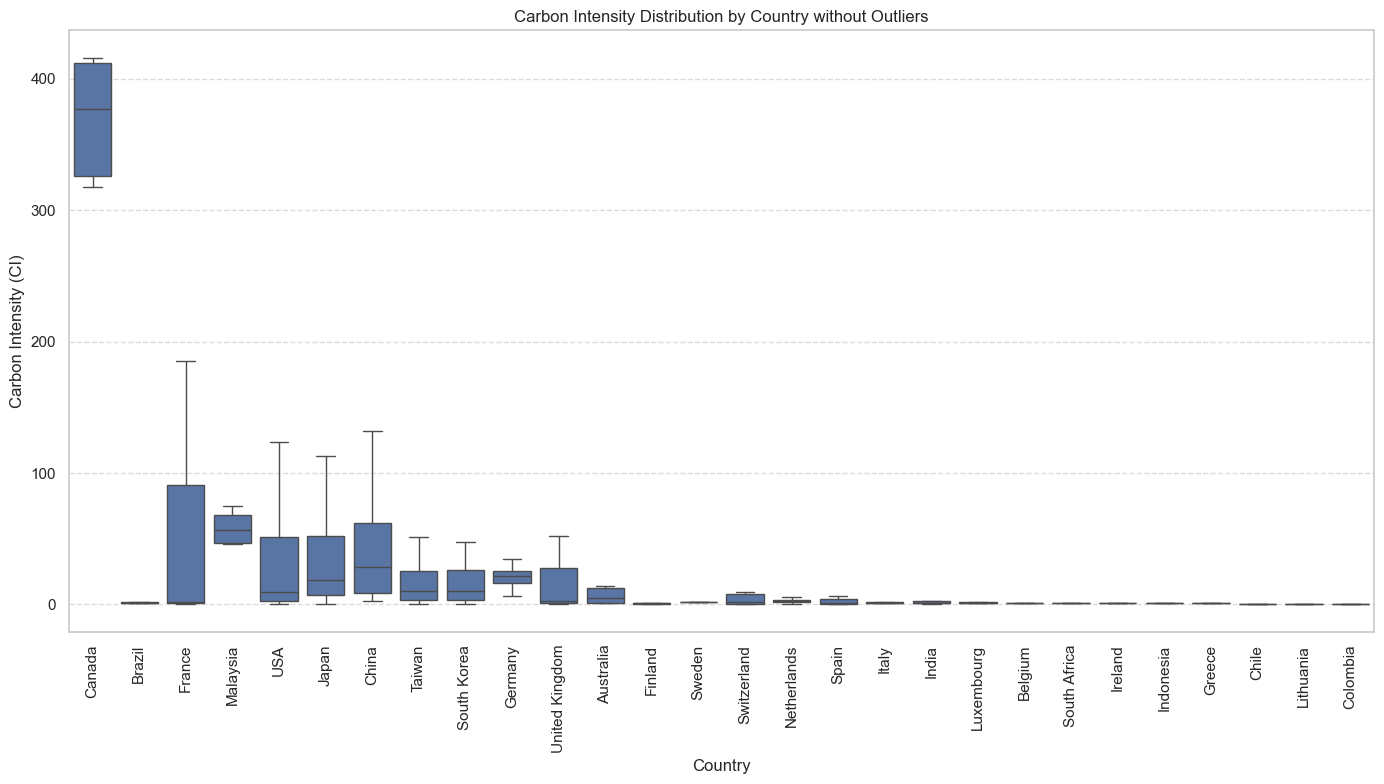

In [11]:
# Boxplot with outliers
sns.set(style = "whitegrid")
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Country (where company is incorporated)', y = '*Carbon intensity', data = df, order = sorted_countries)
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

# Boxplot without outliers
sns.set(style = "whitegrid")
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Country (where company is incorporated)', y = '*Carbon intensity', data = df, order = sorted_countries, showfliers = False)
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Country without Outliers')
plt.xlabel('Country')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

### Quantity of data points varies!

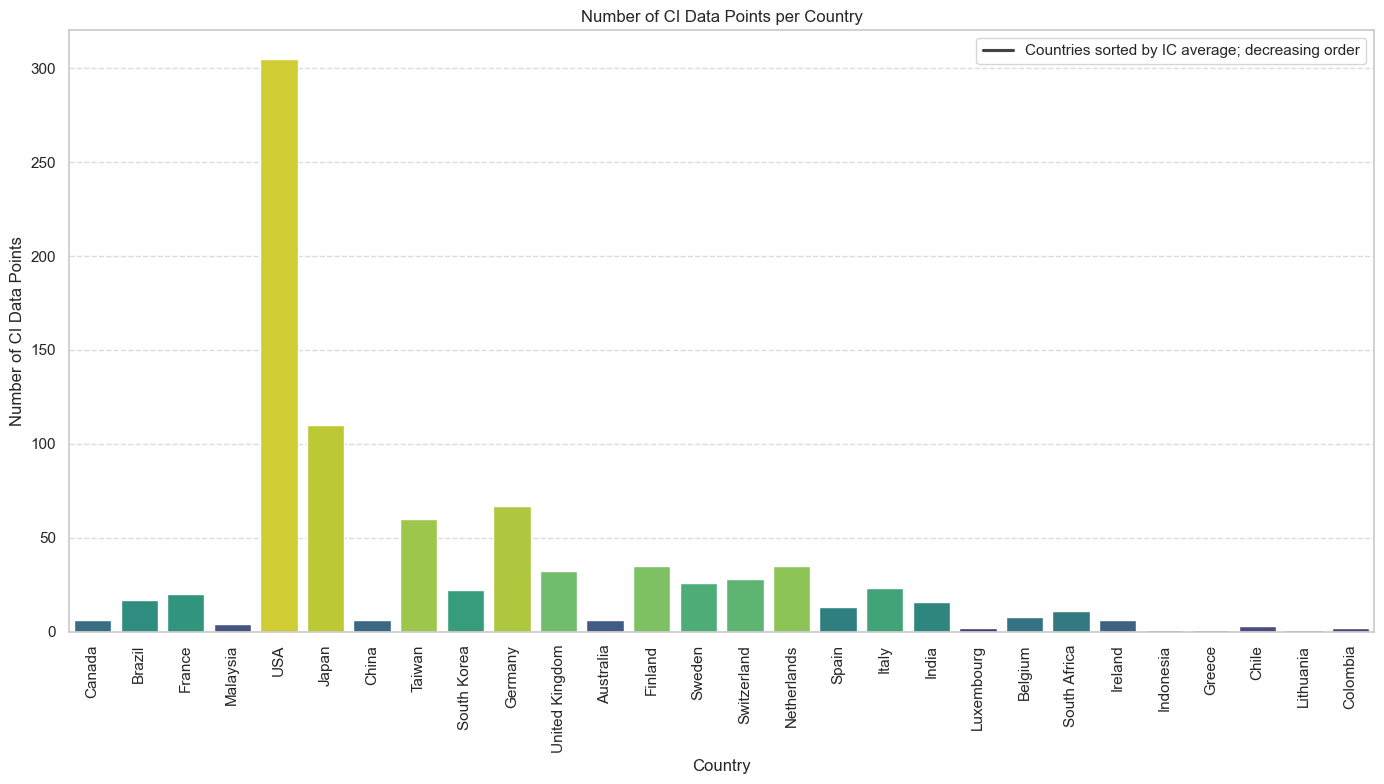

In [24]:
# Number of CI data points per Country
ci_listings_country = df.groupby('Country (where company is incorporated)').size().reset_index(name = 'Count')
ci_listings_country.sort_values(by = 'Count', inplace = True)

# Set the plot size
plt.figure(figsize = (14, 8))
#sns.set(style = "whitegrid")

# Create a bar plot
sns.barplot(x = 'Country (where company is incorporated)', y = 'Count', hue = 'Country (where company is incorporated)', legend = False, data = ci_listings_country, palette = 'viridis', order = sorted_countries)
plt.xticks(rotation = 90)
plt.title('Number of CI Data Points per Country')
plt.xlabel('Country')
plt.ylabel('Number of CI Data Points')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.legend(['Countries sorted by IC average; decreasing order'])
plt.tight_layout()
plt.show()

### Grouping Countries into Regions

Regions based on their geographical location

In [15]:
# Categorizing countries into regions
def categorize_region(country):
    if country in ['USA', 'Canada']:
        return 'North America'
    elif country in ['Brazil', 'Chile', 'Colombia']:
        return 'Latin America'
    elif country in ['Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 
                     'Italy', 'Lithuania', 'Luxembourg', 'Netherlands', 'Spain', 
                     'Sweden', 'Switzerland', 'United Kingdom']:
        return 'Europe'
    elif country in ['China', 'Japan', 'South Korea', 'Taiwan']:
        return 'East Asia'
    elif country in ['India', 'Indonesia', 'Malaysia']:
        return 'Southeast Asia'
    else:
        return 'Other'

ci_listings_country['Region'] = ci_listings_country['Country (where company is incorporated)'].apply(categorize_region)

# Merging to original dataframe
df = df.merge(ci_listings_country[['Country (where company is incorporated)', 'Region']], 
              on = 'Country (where company is incorporated)', how = 'left')

#print(ci_listings_country)

           Region  Count  *Carbon intensity
0           Other     17           4.421765
1  Southeast Asia     21          12.331905
2   Latin America     22          82.125455
3       East Asia    198          37.554646
4          Europe    297          13.851987
5   North America    311          51.357910


/var/folders/v8/1_2rlmrd0wl5w5t5n60h8s440000gn/T/ipykernel_4724/2167182593.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Region', y = 'Count', data = ci_listings_region, palette = 'viridis')


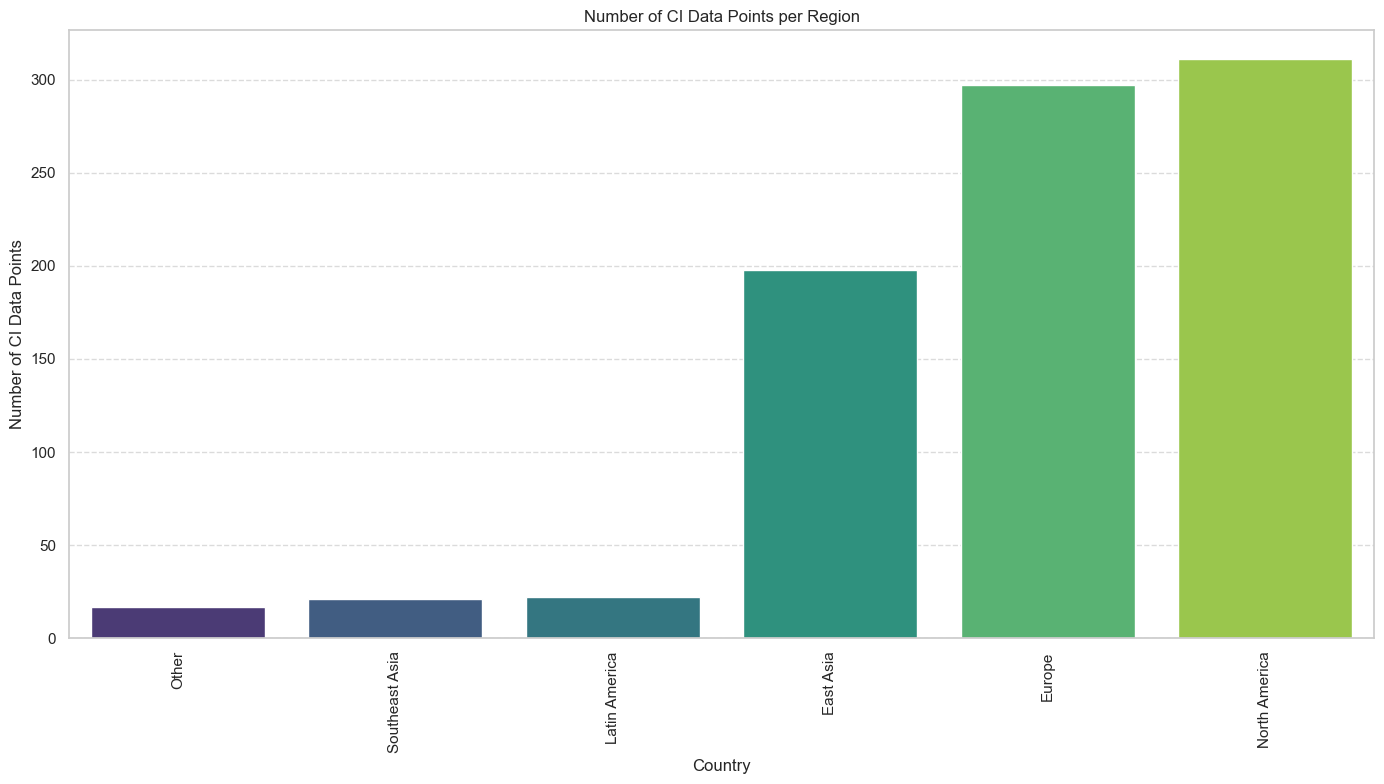

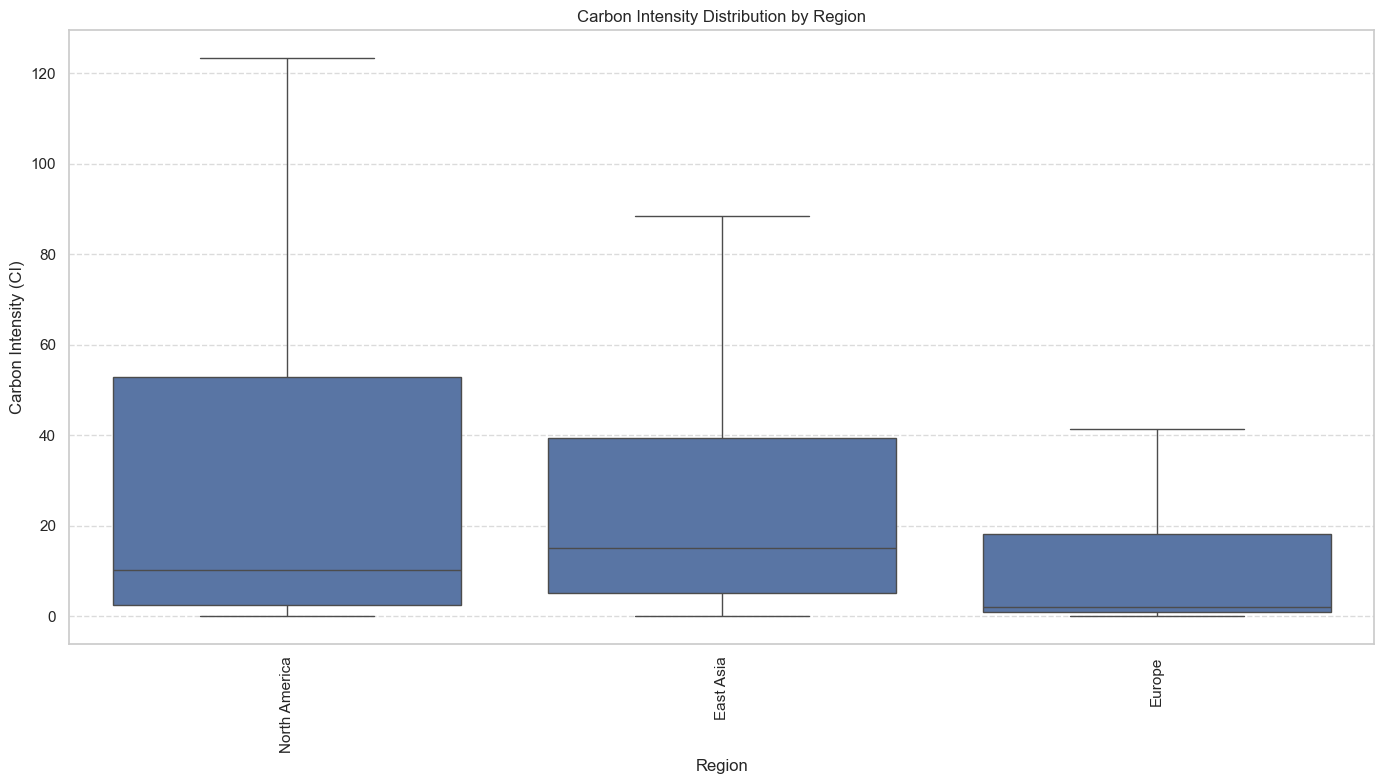

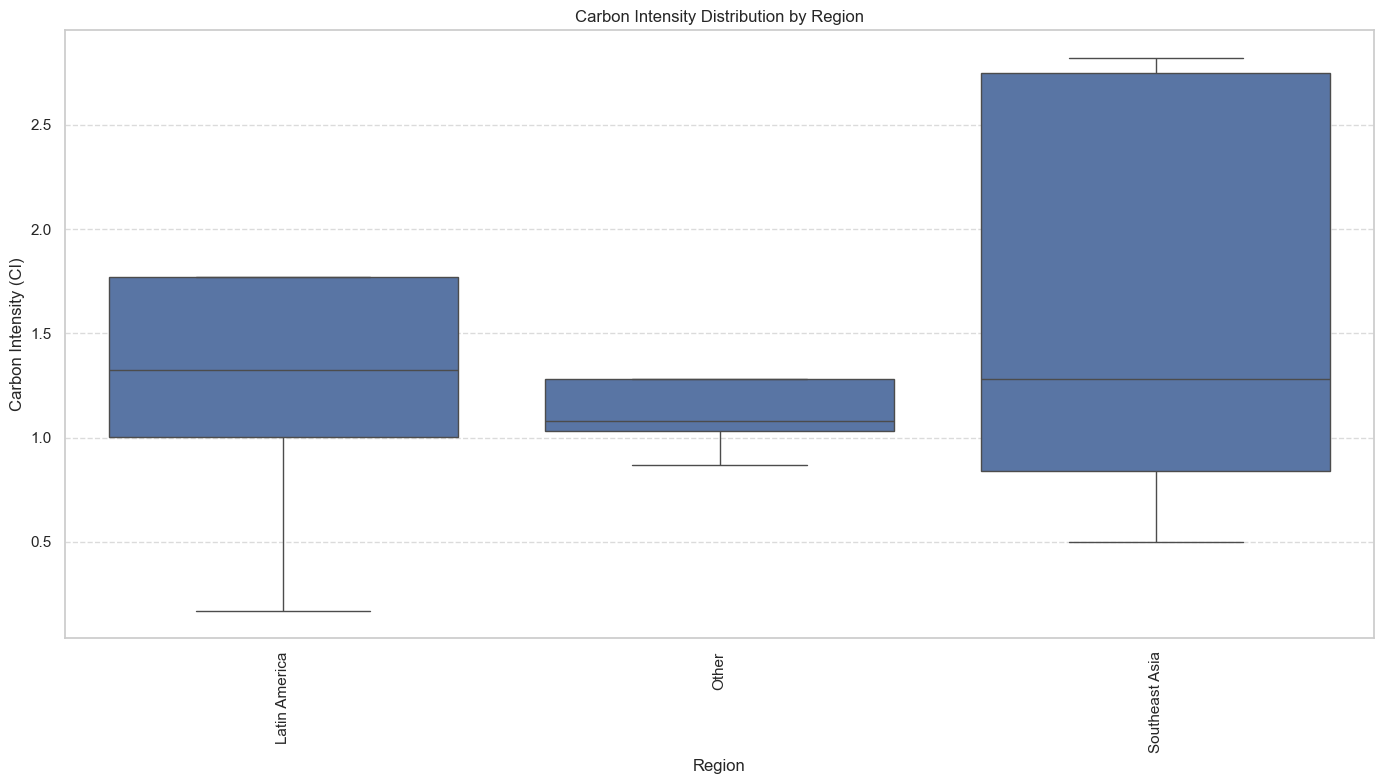

In [20]:
# Calculating region count
ci_listings_region = df.groupby('Region').size().reset_index(name = 'Count')
ci_listings_region.sort_values(by = 'Count', inplace = True)

# Average carbon intesity for each region
ci_avg_region = df.groupby('Region')['*Carbon intensity'].mean()
ci_avg_region = ci_avg_region.sort_values(ascending = False).reset_index()

#merg region count and avg. CI
merged_region_data = ci_listings_region.merge(ci_avg_region, on='Region')
merged_region_data = ci_listings_region.merge(ci_avg_region, on = 'Region')

print(merged_region_data)

# Barplot
plt.figure(figsize = (14, 8))
sns.set(style = "whitegrid")
sns.barplot(x = 'Region', y = 'Count', data = ci_listings_region, palette = 'viridis')
plt.xticks(rotation = 90)
plt.title('Number of CI Data Points per Region')
plt.xlabel('Country')
plt.ylabel('Number of CI Data Points')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

# Splitting in two groups:
region_high_count = ['North America', 'Europe', 'East Asia']
region_low_count = ['Latin America', 'Southeast Asia', 'Other']

# Boxplot for high count regions
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Region', y = '*Carbon intensity', data = df[df['Region'].isin(region_high_count)], showfliers = False) 
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()
# excluding outliers is essential

# Boxplot for low count regions
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Region', y = '*Carbon intensity', data = df[df['Region'].isin(region_low_count)], showfliers = False)
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()
# excluding outliers is essential

In [17]:
print(df['Region'].unique())

['North America' 'East Asia' 'Europe' 'Latin America' 'Other'
 'Southeast Asia']


In [18]:
region_list = ['North America', 'East Asia', 'Europe', 'Latin America', 'Other', 'Southeast Asia']

#### Hisogram

##### before transforming

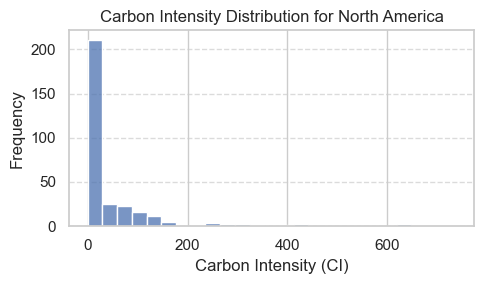

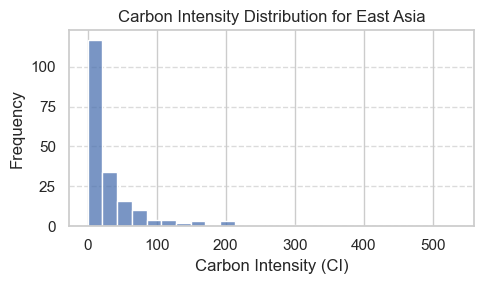

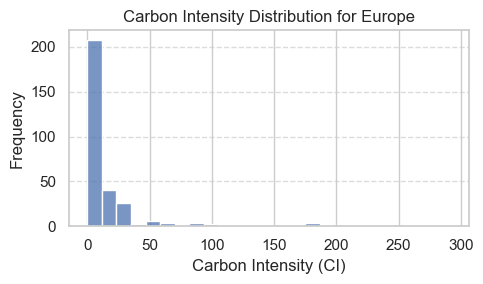

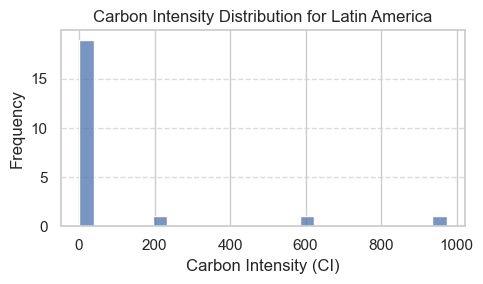

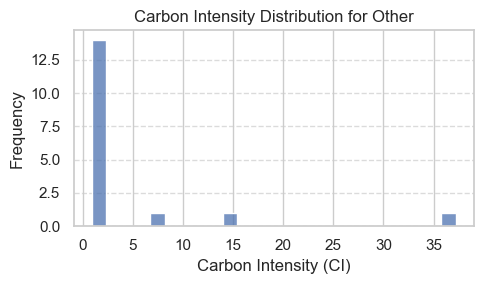

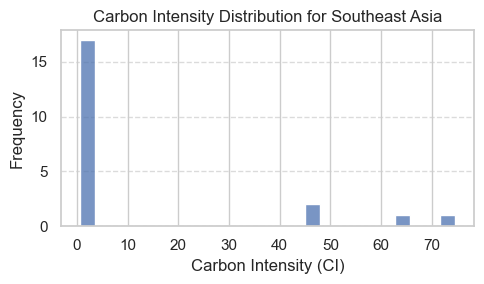

In [19]:
# Loop through each region and create a histogram
for region in region_list:
    plt.figure(figsize = (5, 3))
    sns.histplot(data = df[df['Region'] == region], 
                 x = '*Carbon intensity', 
                 bins = 25, 
                 kde = False)
    plt.title(f'Carbon Intensity Distribution for {region}')
    plt.xlabel('Carbon Intensity (CI)')
    plt.ylabel('Frequency')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
    plt.tight_layout()
    plt.show()

##### log transform to check for normality

In [21]:
df['log_CI'] = np.log(df['*Carbon intensity'] + 1) # to avoid log(0)

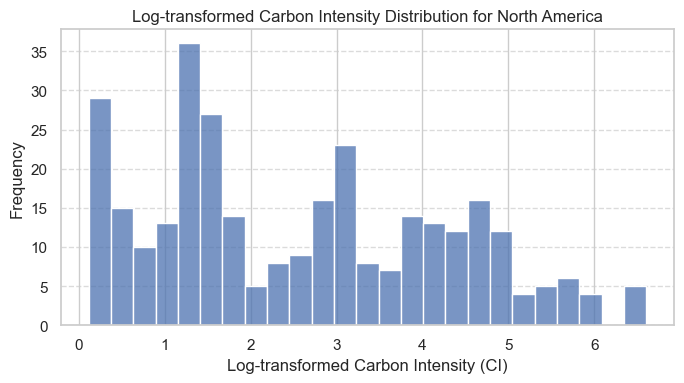

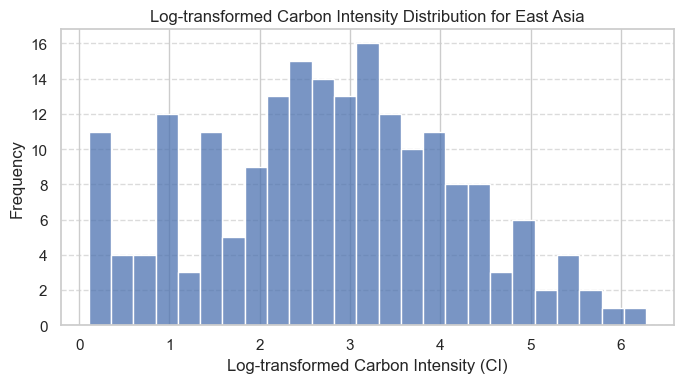

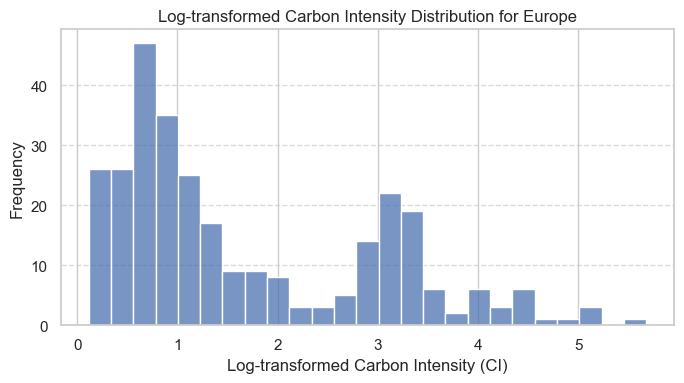

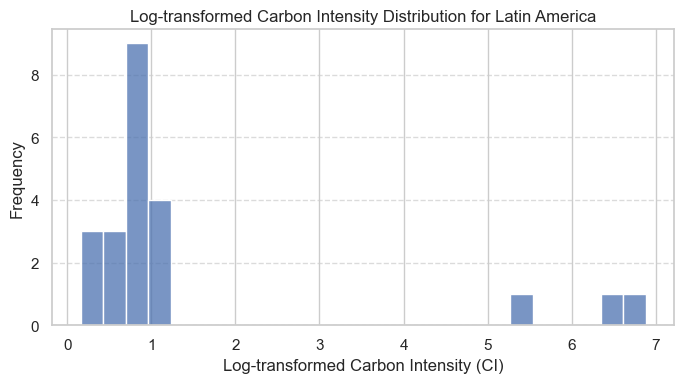

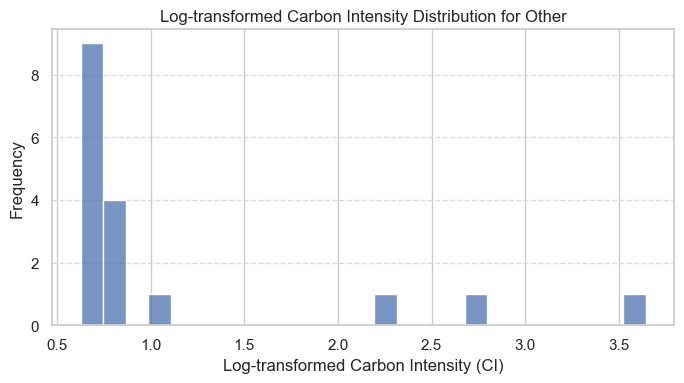

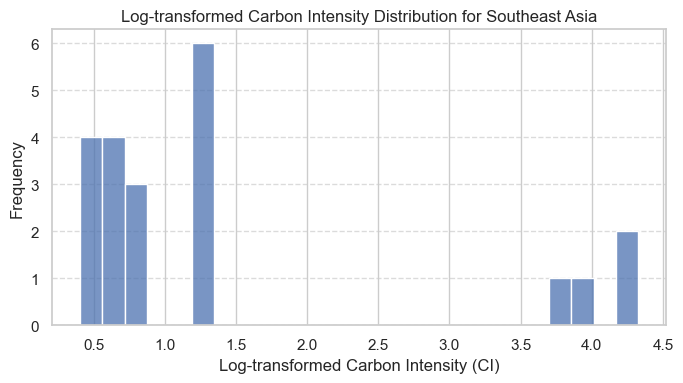

In [22]:
# Loop through each region and create a histogram
for region in region_list:
    plt.figure(figsize = (7, 4))
    sns.histplot(data = df[df['Region'] == region], 
                 x = 'log_CI', 
                 bins = 25, 
                 kde = False)
    plt.title(f'Log-transformed Carbon Intensity Distribution for {region}')
    plt.xlabel('Log-transformed Carbon Intensity (CI)')
    plt.ylabel('Frequency')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
    plt.tight_layout()
    plt.show()

##### Check for normality

In [ ]:
# to verify histogram impression: Check for nomality with Shapiro-Wilk Test
for region in df['Region'].unique():
    region_data = df[df['Region'] == region]['log_CI']
    stat, p_value = stats.shapiro(region_data)
    print(f"Region: {region}, p-value: {p_value:.4f} {'(Not Normal)' if p_value < 0.05 else '(Normal)'}")

Region: North America, p-value: 0.0000 (Not Normal)
Region: East Asia, p-value: 0.0724 (Normal)
Region: Europe, p-value: 0.0000 (Not Normal)
Region: Latin America, p-value: 0.0000 (Not Normal)
Region: Other, p-value: 0.0000 (Not Normal)
Region: Southeast Asia, p-value: 0.0000 (Not Normal)


##### Kruskal Wallis as non-parametric test

In [107]:
# Perform test by grouped regions to satisfy # 3.
region_high_data = [df[df['Region'] == region]['log_CI'] for region in region_high_count]
region_low_data = [df[df['Region'] == region]['log_CI'] for region in region_low_count]

# Test on high count regions
kruskal_stat_high, kruskal_p_value_high = stats.kruskal(*region_high_data)
print(f"High Count Regions - Kruskal-Wallis Test p-value: {kruskal_p_value_high:.4f}")

# Test on low count regions
kruskal_stat_low, kruskal_p_value_low = stats.kruskal(*region_low_data)
print(f"Low Count Regions - Kruskal-Wallis Test p-value: {kruskal_p_value_low:.4f}")


High Count Regions - Kruskal-Wallis Test p-value: 0.0000
Low Count Regions - Kruskal-Wallis Test p-value: 0.8202


In [108]:
# Post hoc test:
df_high_count_region = df[df['Region'].isin(region_high_count)]
posthoc_high = posthoc_dunn(df_high_count_region, val_col = 'log_CI', group_col = 'Region', p_adjust = 'bonferroni')
print("Dunn's Post-hoc Test (High Count Regions):")
print(posthoc_high)

Dunn's Post-hoc Test (High Count Regions):
                  East Asia        Europe  North America
East Asia      1.000000e+00  5.982384e-15   2.372197e-01
Europe         5.982384e-15  1.000000e+00   7.004677e-12
North America  2.372197e-01  7.004677e-12   1.000000e+00


# To be worked on

#### ... Quantity Count 

In [188]:
# Group Countries into data-points quantitiy
ci_listings_country = df.groupby('Country (where company is incorporated)').size().reset_index(name = 'Count')
ci_listings_country_sorted = ci_listings_country.sort_values(by=['Count'], ascending=[False])
print(ci_listings_country_sorted)

   Country (where company is incorporated)  Count
26                                     USA    305
15                                   Japan    110
9                                  Germany     67
25                                  Taiwan     60
19                             Netherlands     35
7                                  Finland     35
27                          United Kingdom     32
24                             Switzerland     28
23                                  Sweden     26
14                                   Italy     23
21                             South Korea     22
8                                   France     20
2                                   Brazil     17
11                                   India     16
22                                   Spain     13
20                            South Africa     11
1                                  Belgium      8
0                                Australia      6
5                                    China      6


In [189]:
# Grouping similar listing-quantities
def categorize_country(count):
    if count > 100:
        return 'Above 100'
    elif 50 <= count <= 100:
        return '50 to 100'
    elif 20 <= count < 50:
        return '20 to 49'
    elif 10 <= count < 20:
        return '10 to 19'
    else:
        return 'Below 10'
    
ci_listings_country['CI Listings'] = CI_listings_country['Count'].apply(categorize_country)
ci_listings_country_sorted = ci_listings_country.sort_values(by = ['Count'], ascending = [False])
print(ci_listings_country_sorted)

   Country (where company is incorporated)  Count CI Listings
26                                     USA    305   Above 100
15                                   Japan    110   Above 100
9                                  Germany     67   50 to 100
25                                  Taiwan     60   50 to 100
19                             Netherlands     35    20 to 49
7                                  Finland     35    20 to 49
27                          United Kingdom     32    20 to 49
24                             Switzerland     28    20 to 49
23                                  Sweden     26    20 to 49
14                                   Italy     23    20 to 49
21                             South Korea     22    20 to 49
8                                   France     20    20 to 49
2                                   Brazil     17    10 to 19
11                                   India     16    10 to 19
22                                   Spain     13    10 to 19
20      

In [190]:
df = df.merge(ci_listings_country[['Country (where company is incorporated)', 'CI Listings']], 
              on='Country (where company is incorporated)', how = 'left')

In [191]:
df.head()

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,...,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any),Region,CI Listings
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,...,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...,North America,Above 100
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,...,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...,North America,Above 100
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,...,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c...",North America,Above 100
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN,East Asia,Above 100
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN,East Asia,Above 100


##### by countries

In [192]:
def remove_outliers_by_country(df, group_column, value_column):
    """
    Removes outliers for the specified value column grouped by the group_column using the IQR method.
    """
    def remove_outliers(group):
        Q1 = group[value_column].quantile(0.25)
        Q3 = group[value_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[value_column] >= lower_bound) & (group[value_column] <= upper_bound)]
    
    # Apply the outlier removal function to each group (country)
    return df.groupby(group_column).apply(remove_outliers).reset_index(drop=True)

# removing outliers and create new df
df_no_outliers_countries = remove_outliers_by_country(df, 'Country (where company is incorporated)', '*Carbon intensity')

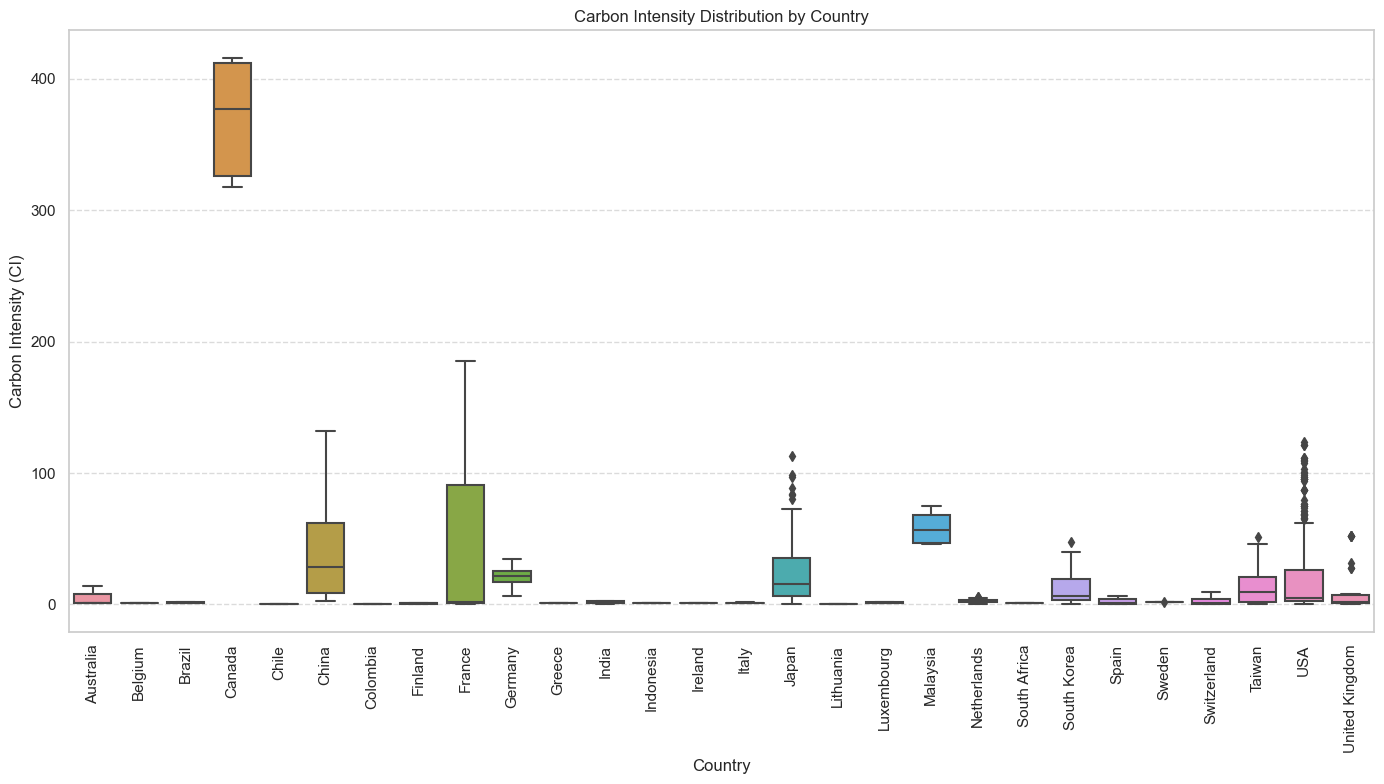

In [193]:
sns.set(style = "whitegrid")
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Country (where company is incorporated)', y = '*Carbon intensity', data = df_no_outliers_countries)
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

##### by region

In [194]:
def remove_outliers_by_region(df, group_column, value_column):
    """
    Removes outliers for the specified value column grouped by the group_column using the IQR method.
    """
    # Initialize an empty list to store filtered data
    filtered_rows = []
    
    # Group by the specified column (Region)
    for _, group in df.groupby(group_column):
        Q1 = group[value_column].quantile(0.25)
        Q3 = group[value_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers based on the IQR bounds
        filtered_group = group[(group[value_column] >= lower_bound) & (group[value_column] <= upper_bound)]
        filtered_rows.append(filtered_group)
    
    # Concatenate the filtered groups back into a single dataframe
    return pd.concat(filtered_rows, axis=0).reset_index(drop=True)

# Apply the function to remove outliers by region
df_no_outliers_region = remove_outliers_by_region(df, 'Region', '*Carbon intensity')

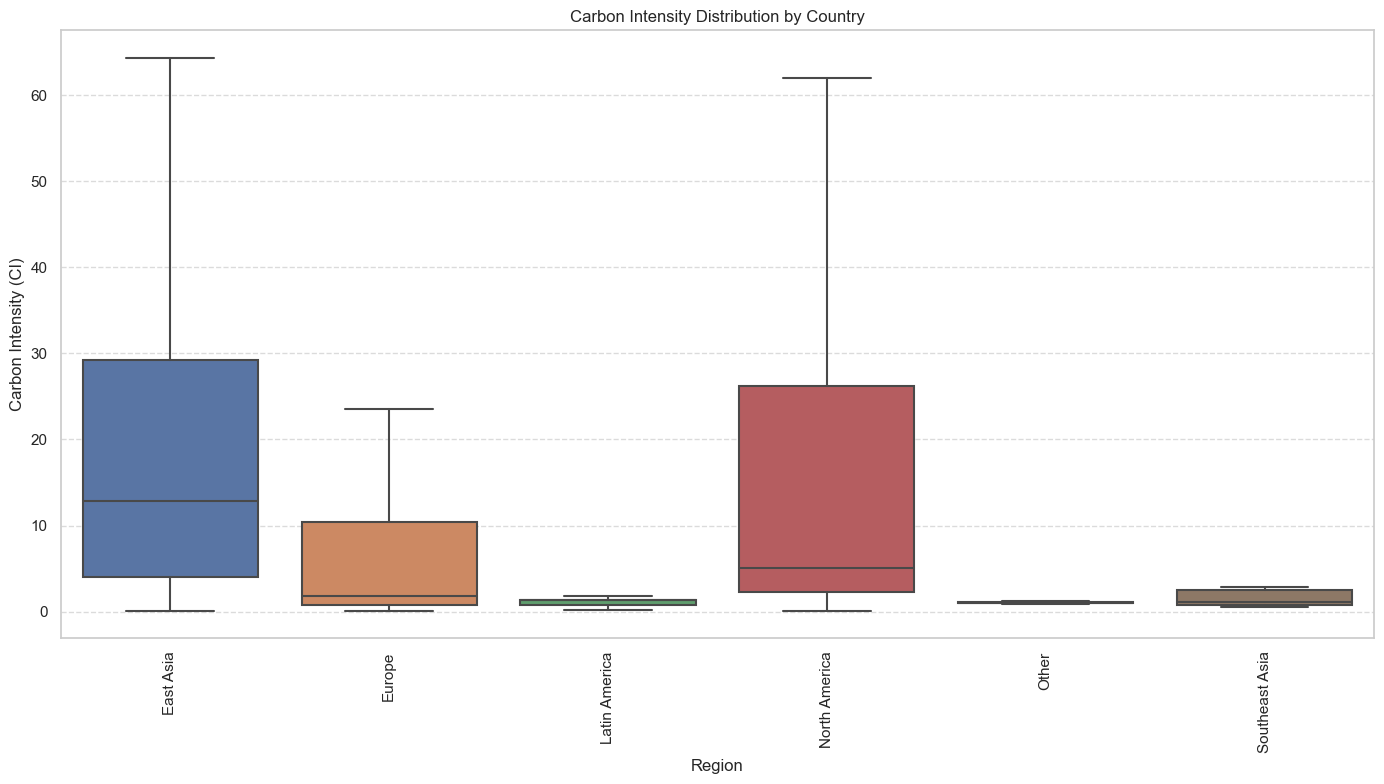

In [179]:
sns.set(style = "whitegrid")
plt.figure(figsize = (14, 8))
sns.boxplot(x = 'Region', y = '*Carbon intensity', data = df_no_outliers_region, showfliers = False) # this function surpresses to calculate new outliers
plt.xticks(rotation = 90)
plt.title('Carbon Intensity Distribution by Country')
plt.xlabel('Region')
plt.ylabel('Carbon Intensity (CI)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

### Boxplots over...

#### ... CI listings Groups

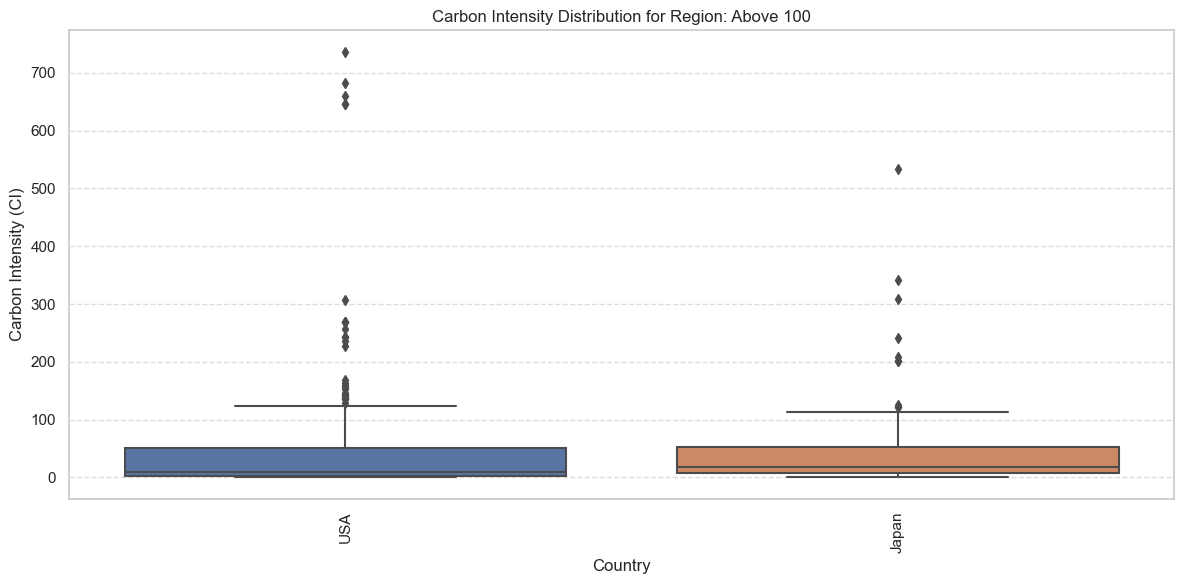

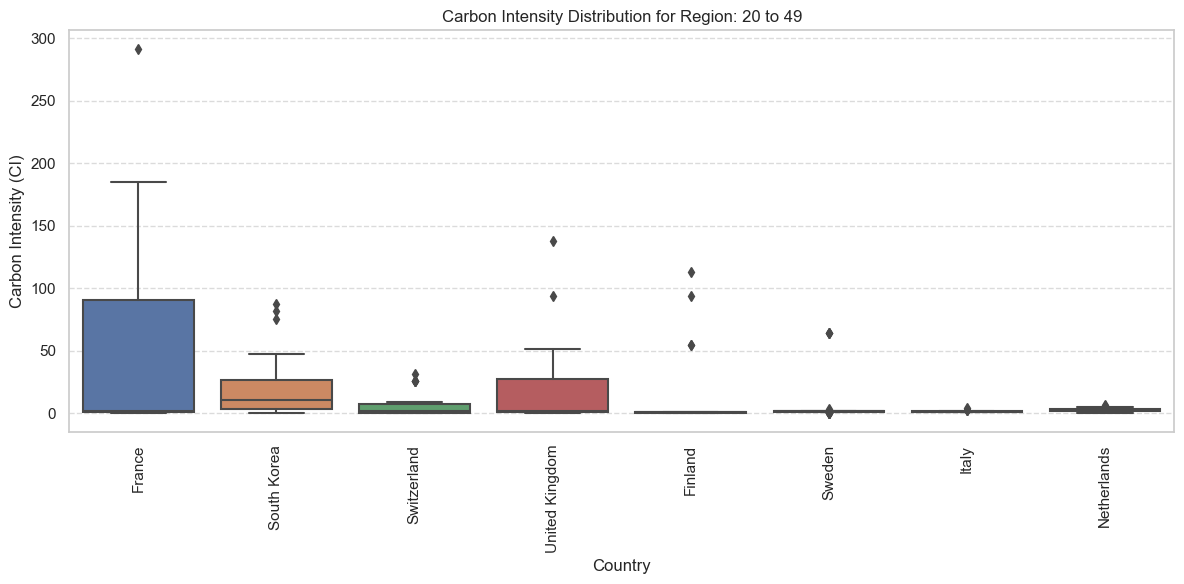

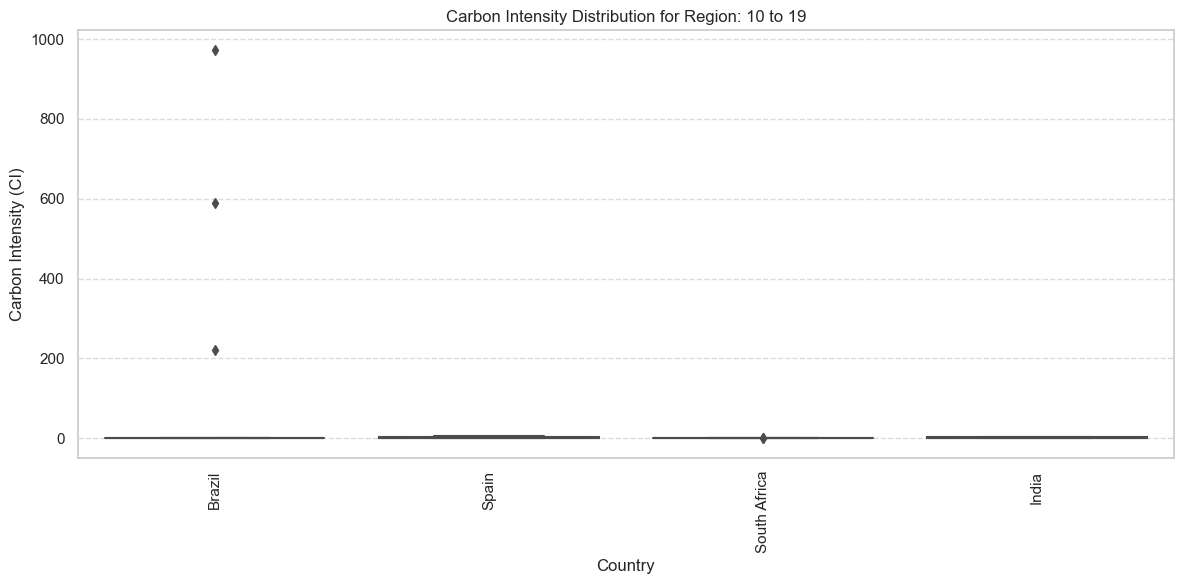

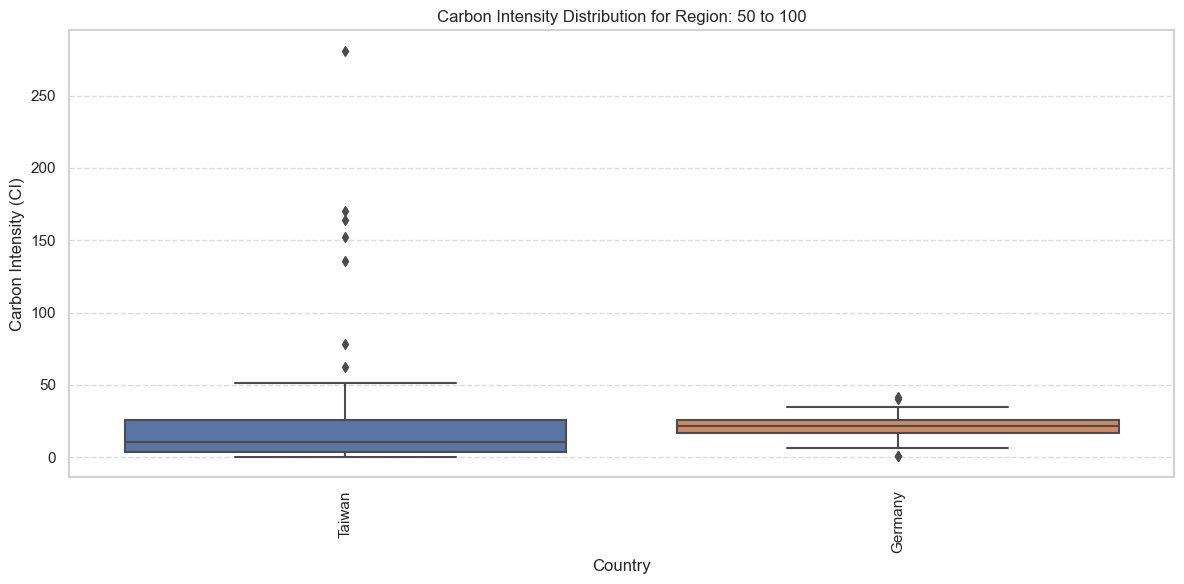

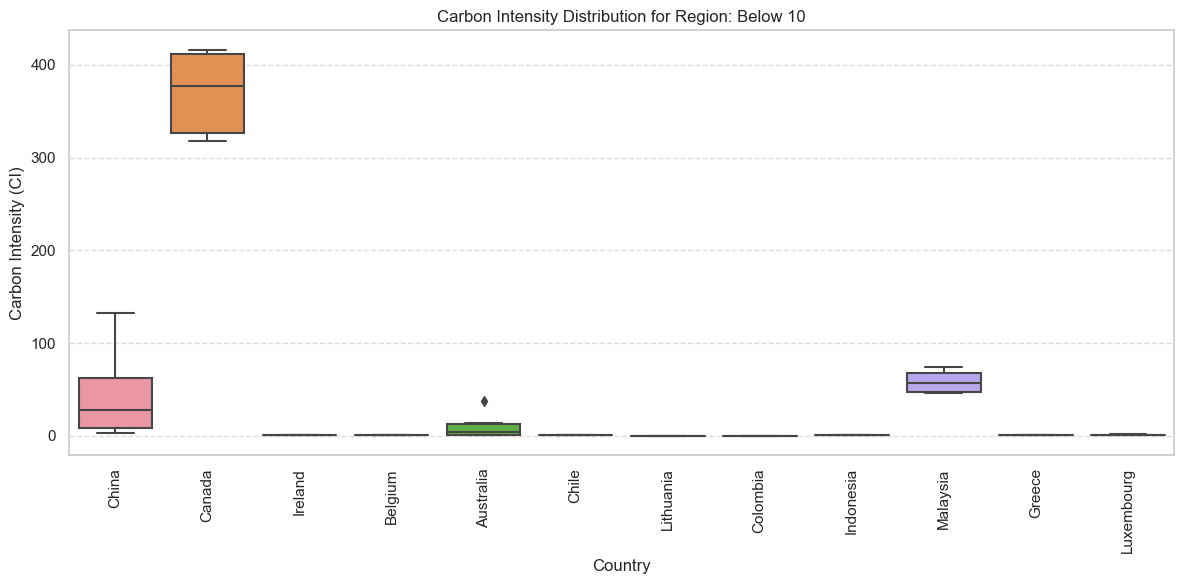

In [197]:
sns.set(style = "whitegrid")
listings = df['CI Listings'].unique()

for listing in listings:
    plt.figure(figsize = (12, 6))
    sns.boxplot(x = 'Country (where company is incorporated)', 
                y = '*Carbon intensity', 
                data=df[df['CI Listings'] == listing])
    plt.xticks(rotation=90)
    plt.title(f'Carbon Intensity Distribution for Region: {listing}')
    plt.ylabel('Carbon Intensity (CI)')
    plt.xlabel('Country')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# removing outliers
def remove_outliers(df, column):
    """
    Removes outliers from the specified column using the IQR method.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

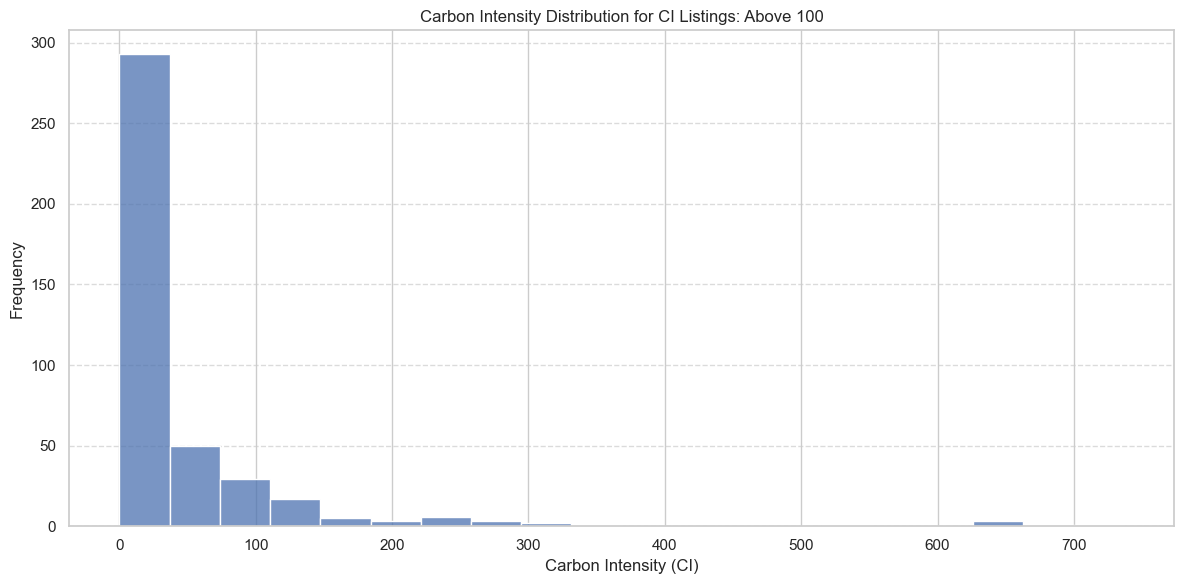

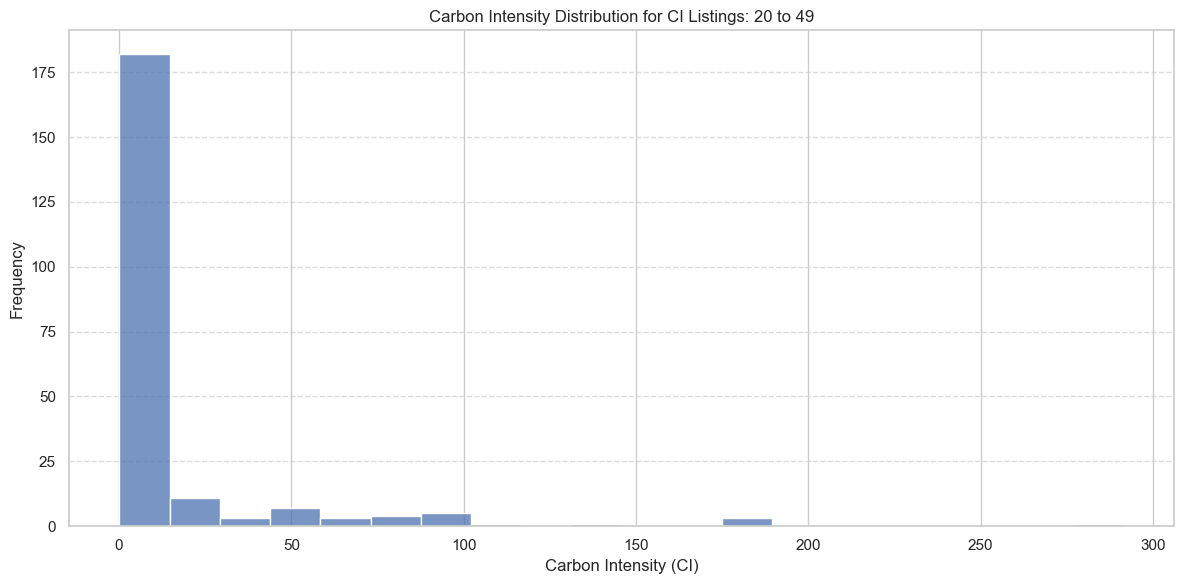

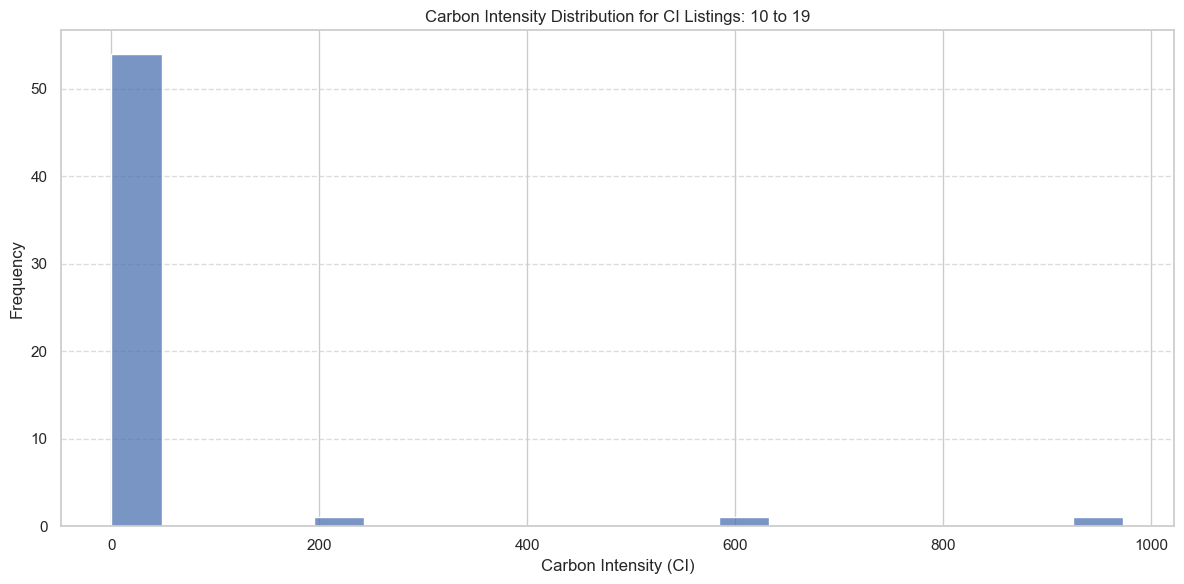

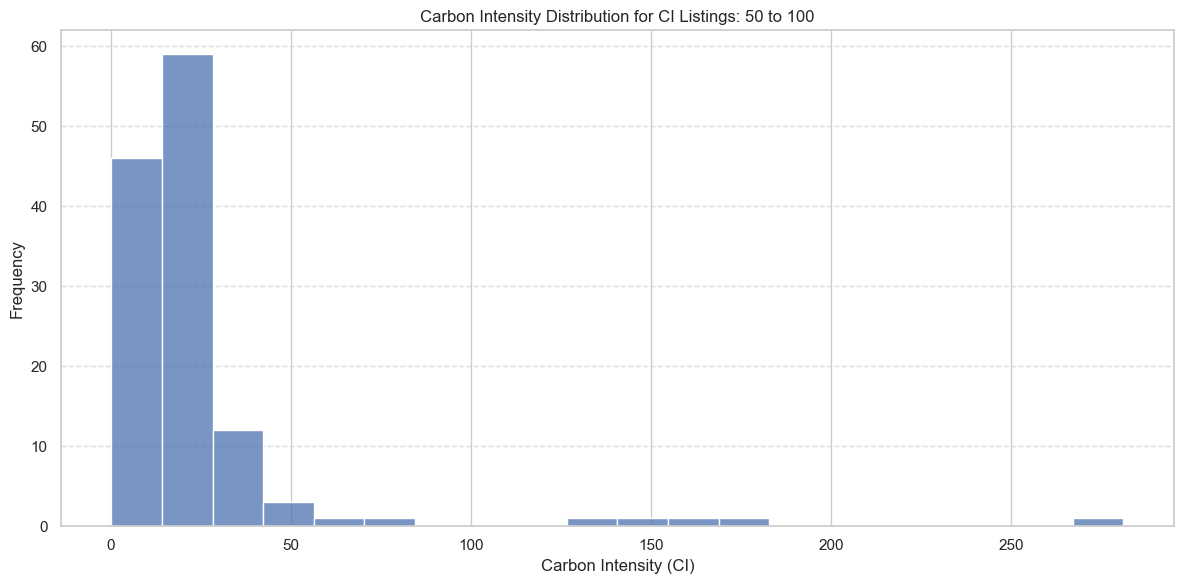

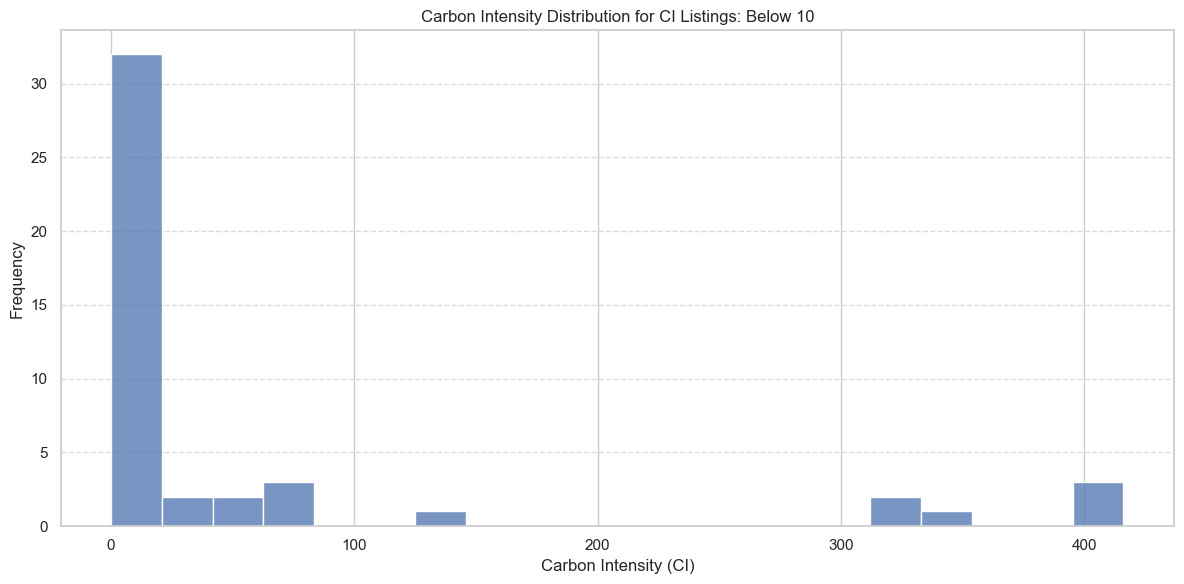

In [146]:
sns.set(style="whitegrid")

listings = df['CI Listings'].unique()

for listing in listings:
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data = df[df['CI Listings'] == listing], 
        x = '*Carbon intensity', 
        bins = 20, 
        kde = False
    )
    plt.title(f'Carbon Intensity Distribution for CI Listings: {listing}')
    plt.xlabel('Carbon Intensity (CI)')
    plt.ylabel('Frequency')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
    plt.tight_layout()
    plt.show()

#### Over Region

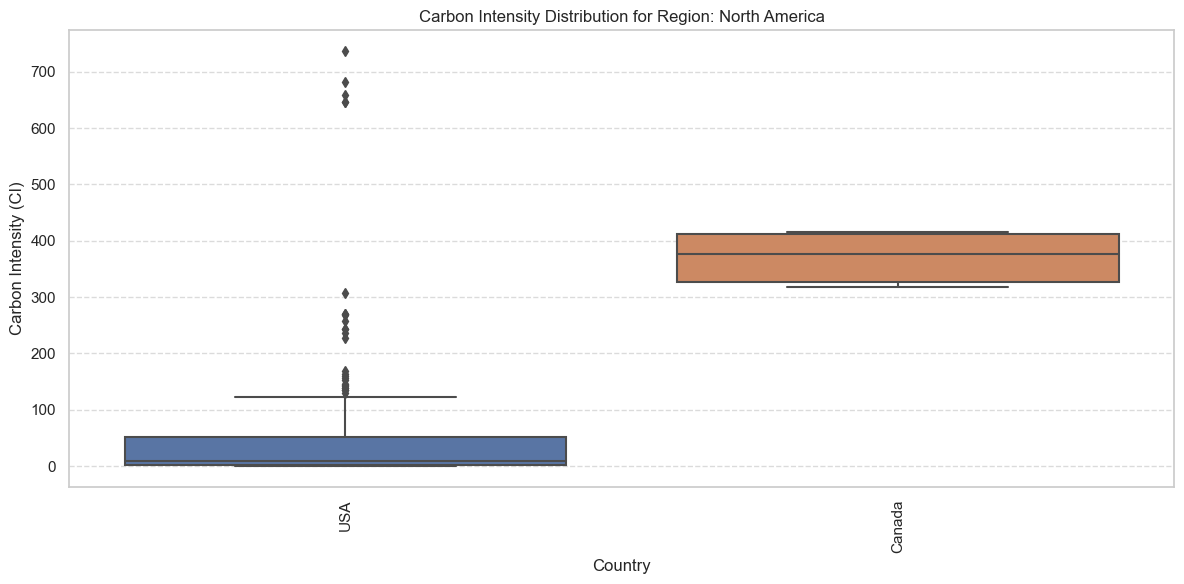

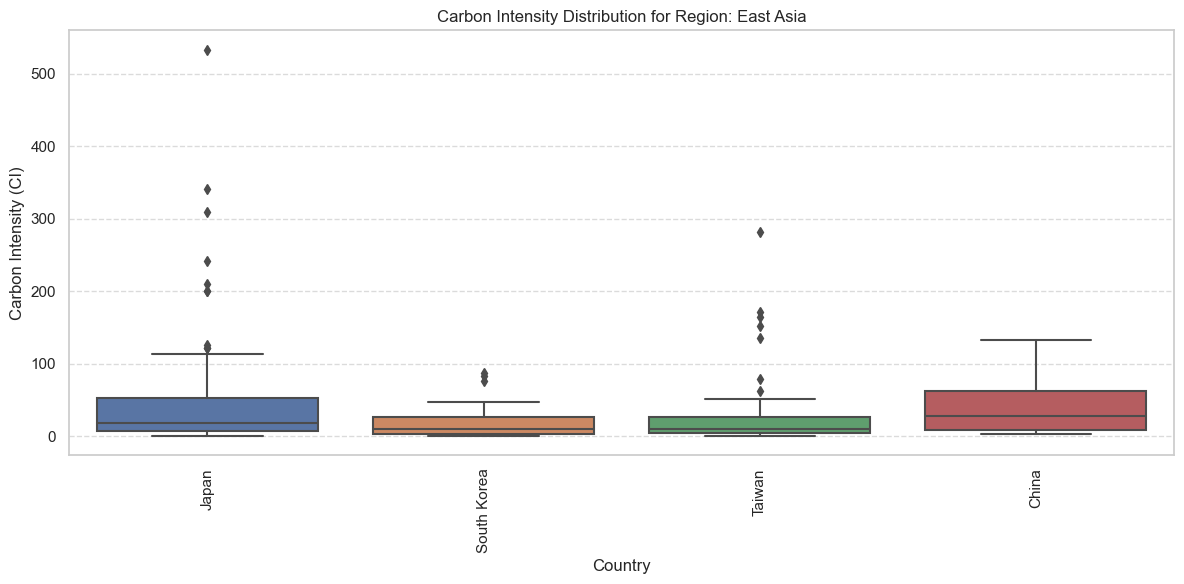

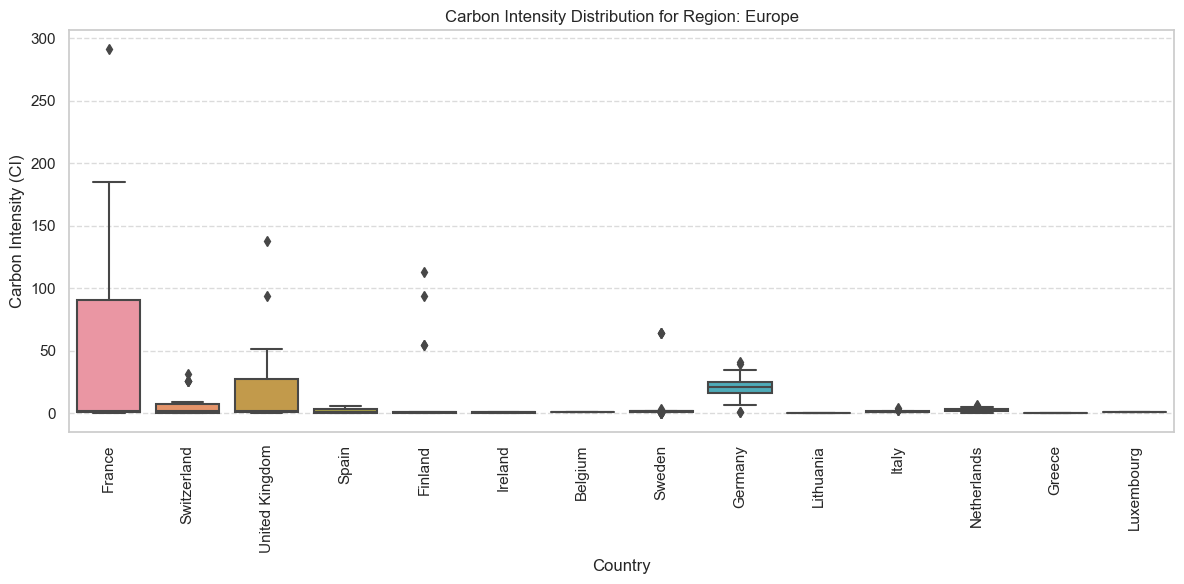

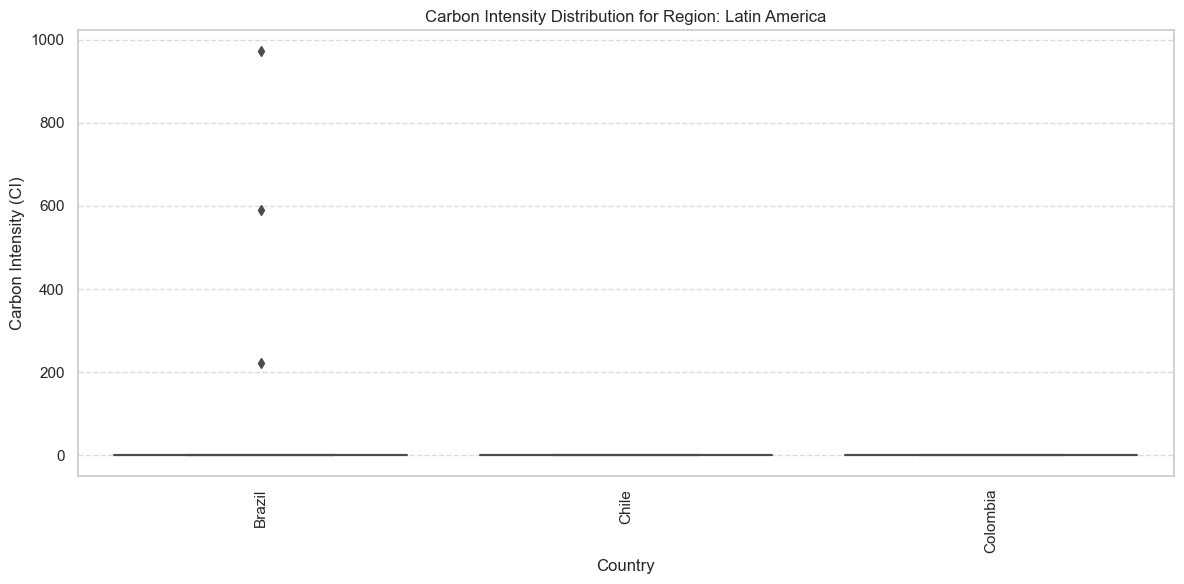

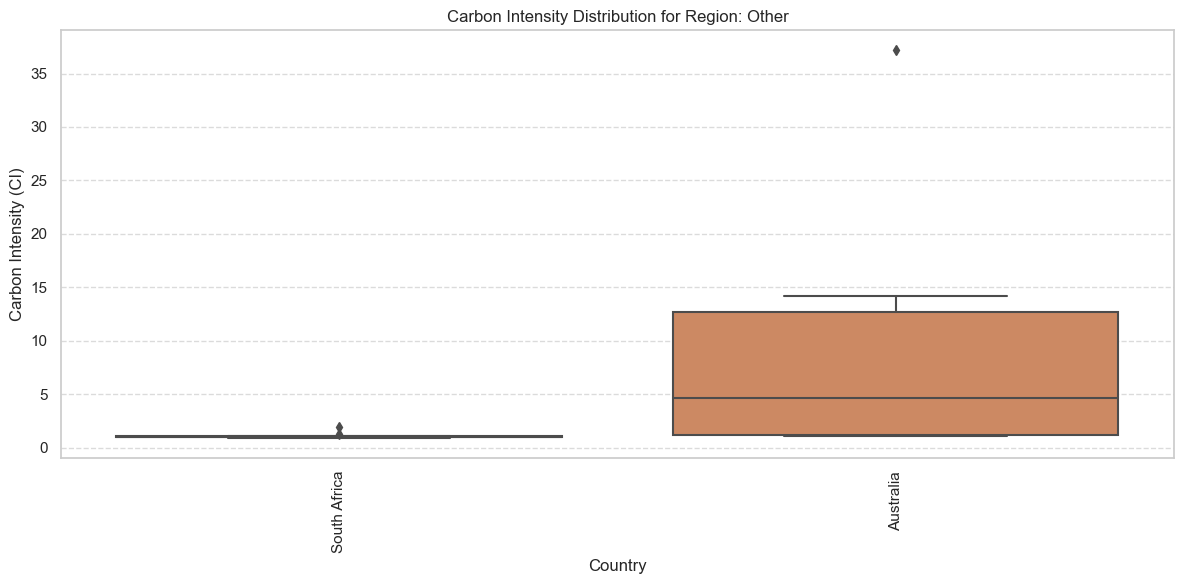

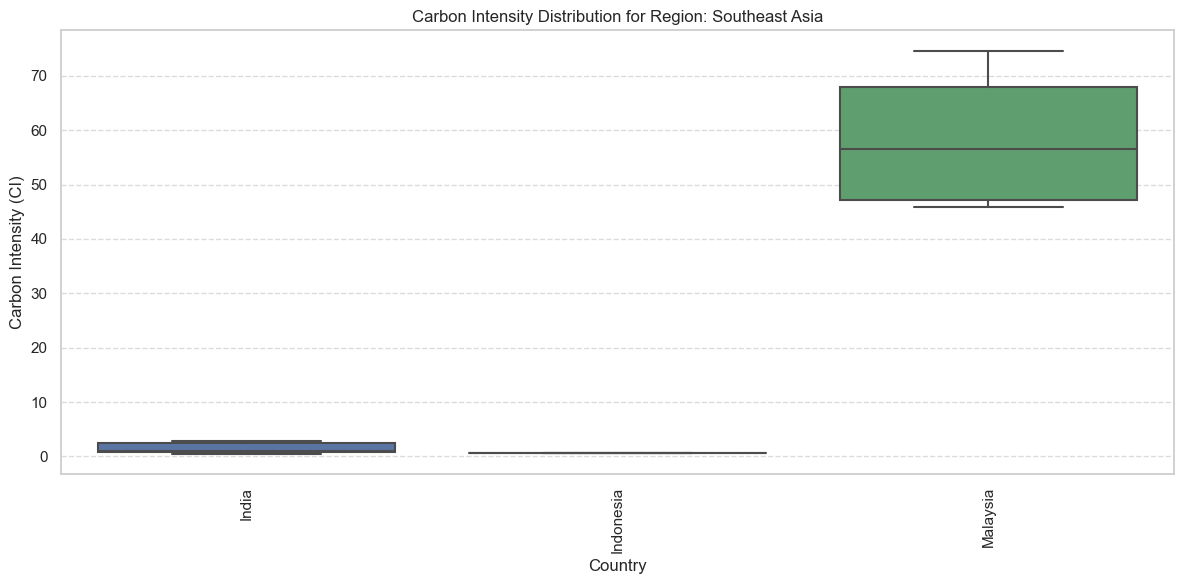

In [138]:
sns.set(style = "whitegrid")
regions = df['Region'].unique()

for region in regions:
    plt.figure(figsize = (12, 6))
    sns.boxplot(x = 'Country (where company is incorporated)', 
                y = '*Carbon intensity', 
                data=df[df['Region'] == region])
    plt.xticks(rotation=90)
    plt.title(f'Carbon Intensity Distribution for Region: {region}')
    plt.ylabel('Carbon Intensity (CI)')
    plt.xlabel('Country')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
    plt.tight_layout()
    plt.show()